In [1]:
import numpy as np
import pandas
import networkx as nx
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statannot import add_stat_annotation
import glob
from tqdm.notebook import tqdm
from numpy import random
from scipy import stats

import copy
import griottes
import griottes.analyse
from griottes.graphmaker import make_spheroids
from griottes.graphmaker import graph_generation_func
from griottes.graphplotter import graph_plot

# Notebook to compute contact between progenitor cells and stroma on a graph (relative to figure 3)

Here, everything is provided for the example image, in the Zenodo repository, in the folder "Example_image" or in this repository to run this notebook in the folder "Example_image"

# Useful function to extract neighbors properties

In [6]:
def get_neighborhood_properties(G, dataframe):
    """
    Graph needs to have "cell_properties" as attribute per node.
    Returns:
    --------
    pandas.DataFrame: line inpt cell type, columns are prob for line
        cell type to have column cell type as neighbor.
    """
    cell_property_kinds = dataframe.cell_properties.unique()
    
    df = copy.copy(dataframe)
    for neigh in cell_property_kinds:
        df[neigh + ' neighbor'] = 0
        
    df['graph_cell_properties'] = ' '
        
    for node in tqdm(G.nodes()):
        df.loc[node, 'graph_cell_properties'] = G.nodes[node]['cell_properties']
        for neigh_node in G.neighbors(node):
            neigh_node_cell_type = G.nodes[neigh_node]['cell_properties']
            df.loc[node, neigh_node_cell_type + ' neighbor'] += 1
    return df

# Load an example dataset and make graphs

In [4]:
fname = 'Example_image/221212_6_classified_corrected.csv'
dft_221212_6 = pandas.read_csv(fname)

In [ ]:
# Build graph on the image using Delaunay method

descriptors = ['label', 'cell_type', 'color', 'legend','cell_properties','x', 'y']
Observed_graph = graph_generation_func.generate_delaunay_graph(dft_221212_6,
                                                  image_is_2D = True,
                                                  descriptors = descriptors,
                                                  distance = 100)

# Extract cell neighbors on the graph
neighbors_graph = get_neighborhood_properties(Observed_graph, dft_221212_6)

In [ ]:
# Duplicate the dataset 5 times and randomly assign cell that are not Lhx2+ (to keep the structure of stellate cells intact)

selected_columns = ['label', 'x', 'y', 'cell_properties', 'cell_properties_CD45', 'cell_properties_Kit', 'cell_properties_Lhx2', 'color', 'legend', 'date']
columns_to_shuffle = ['cell_properties_CD45', 'cell_properties_Kit']

data_221212_6_random_all = []

for i in tqdm([q for q in range(5)]):
    data_221212_6_random_lhx2neg = copy.copy(dft_221212_6.loc[dft_221212_6.cell_properties_Lhx2 != 'Lhx2+']).reset_index()
    data_221212_6_random_lhx2pos = copy.copy(dft_221212_6.loc[dft_221212_6.cell_properties_Lhx2 == 'Lhx2+']).reset_index()
    data_221212_6_random_lhx2neg[columns_to_shuffle] = data_221212_6_random_lhx2neg[columns_to_shuffle].sample(frac = 1).reset_index().drop('index', axis=1)
    data_221212_6_random = pandas.concat([data_221212_6_random_lhx2pos, data_221212_6_random_lhx2neg]).reset_index()
    data_221212_6_random.cell_properties = data_221212_6_random.cell_properties_CD45 + ', ' + data_221212_6_random.cell_properties_Kit + ', ' + data_221212_6_random.cell_properties_Lhx2
    data_221212_6_random_all.append(data_221212_6_random)

In [ ]:
# Build graph on the image using Delaunay method and extract cell neighbors on the random datasets

neighbors_221212_6_random = []

for i in tqdm([k for k in range(5)]):
    descriptors = ['label', 'cell_type', 'color', 'legend','cell_properties','x', 'y']
    Random_graph = graph_generation_func.generate_delaunay_graph(data_221212_6_random_all[i],
                                                                 image_is_2D = True,
                                                                 descriptors = descriptors,
                                                                 distance = 100)
    M = get_neighborhood_properties(Random_graph, data_221212_6_random_all[i])
    neighbors_221212_6_random.append(M)

# Compute number of contact to a LHX2$^+$cell for each cell type

In [16]:
cell_type = 'CD45-, Kit+, Lhx2-'
neighbor_type = 'CD45-, Kit-, Lhx2+ neighbor'

neighbors_graph['fraction'] = 1
Kit_221212_6 = neighbors_graph.loc[neighbors_graph.graph_cell_properties == cell_type].groupby([neighbor_type]).count().reset_index()[[neighbor_type, 'fraction']]
number_cells = np.sum(Kit_221212_6['fraction'])
Kit_221212_6['fraction'] = 100*Kit_221212_6['fraction']/number_cells

Kit_221212_6_random = pandas.DataFrame()
for i in range(len(neighbors_221212_6_random)):
    n_1 = neighbors_221212_6_random[i]
    n_1['fraction'] = 1
    t_1_random = n_1.loc[n_1.graph_cell_properties == cell_type].groupby([neighbor_type]).count().reset_index()[[neighbor_type, 'fraction']]
    number_cells = np.sum(t_1_random['fraction'])
    t_1_random['fraction'] = 100*t_1_random['fraction']/number_cells
    Kit_221212_6_random = pandas.concat([Kit_221212_6_random, t_1_random])
Kit_221212_6_random = Kit_221212_6_random.groupby(neighbor_type).mean().reset_index()

Kit_221212_6['date'] = 221212_6
Kit_221212_6_random['date'] = 221212_6

Kit_221212_6['type'] = 'observed'
Kit_221212_6_random['type'] = 'random'

Contact_Kit_LHX2 = pandas.concat([Kit_221212_6, Kit_221212_6_random])

In [23]:
cell_type = 'CD45+, Kit+, Lhx2-'
neighbor_type = 'CD45-, Kit-, Lhx2+ neighbor'

neighbors_graph['fraction'] = 1
CD45_Kit_221212_6 = neighbors_graph.loc[neighbors_graph.graph_cell_properties == cell_type].groupby([neighbor_type]).count().reset_index()[[neighbor_type, 'fraction']]
number_cells = np.sum(CD45_Kit_221212_6['fraction'])
CD45_Kit_221212_6['fraction'] = 100*CD45_Kit_221212_6['fraction']/number_cells

CD45_Kit_221212_6_random = pandas.DataFrame()
for i in range(len(neighbors_221212_6_random)):
    n_1 = neighbors_221212_6_random[i]
    n_1['fraction'] = 1
    t_1_random = n_1.loc[n_1.graph_cell_properties == cell_type].groupby([neighbor_type]).count().reset_index()[[neighbor_type, 'fraction']]
    number_cells = np.sum(t_1_random['fraction'])
    t_1_random['fraction'] = 100*t_1_random['fraction']/number_cells
    CD45_Kit_221212_6_random = pandas.concat([CD45_Kit_221212_6_random, t_1_random])
CD45_Kit_221212_6_random = CD45_Kit_221212_6_random.groupby(neighbor_type).mean().reset_index()

CD45_Kit_221212_6['date'] = 221212_6
CD45_Kit_221212_6_random['date'] = 221212_6

CD45_Kit_221212_6['type'] = 'observed'
CD45_Kit_221212_6_random['type'] = 'random'

Contact_CD45_Kit_LHX2 = pandas.concat([CD45_Kit_221212_6, CD45_Kit_221212_6_random])

In [24]:
cell_type = 'CD45+, Kit-, Lhx2-'
neighbor_type = 'CD45-, Kit-, Lhx2+ neighbor'

neighbors_graph['fraction'] = 1
CD45_221212_6 = neighbors_graph.loc[neighbors_graph.graph_cell_properties == cell_type].groupby([neighbor_type]).count().reset_index()[[neighbor_type, 'fraction']]
number_cells = np.sum(CD45_221212_6['fraction'])
CD45_221212_6['fraction'] = 100*CD45_221212_6['fraction']/number_cells

CD45_221212_6_random = pandas.DataFrame()
for i in range(len(neighbors_221212_6_random)):
    n_1 = neighbors_221212_6_random[i]
    n_1['fraction'] = 1
    t_1_random = n_1.loc[n_1.graph_cell_properties == cell_type].groupby([neighbor_type]).count().reset_index()[[neighbor_type, 'fraction']]
    number_cells = np.sum(t_1_random['fraction'])
    t_1_random['fraction'] = 100*t_1_random['fraction']/number_cells
    CD45_221212_6_random = pandas.concat([CD45_221212_6_random, t_1_random])
CD45_221212_6_random = CD45_221212_6_random.groupby(neighbor_type).mean().reset_index()

CD45_221212_6['date'] = 221212_6
CD45_221212_6_random['date'] = 221212_6

CD45_221212_6['type'] = 'observed'
CD45_221212_6_random['type'] = 'random'

Contact_CD45_LHX2 = pandas.concat([CD45_221212_6, CD45_221212_6_random])

# Plot distribution of number of contact between each cell types and LHX2$^+$cells

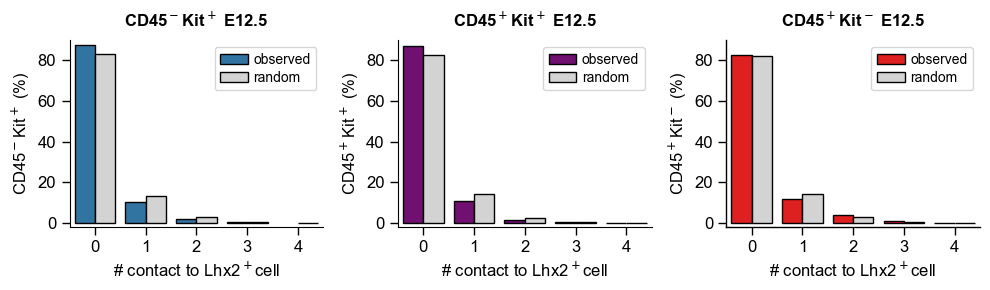

In [26]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, 3, figsize = (10,3))

order = [0,1,2,3,4]

sns.barplot(ax=ax[0],
                 x = neighbor_type,
                 y = 'fraction',
                 hue = 'type',
                 data=Contact_Kit_LHX2,
                 order = order,
                 palette = ['tab:blue', 'lightgray'],
                 errorbar='sd',
                 errcolor='black',
                 capsize=0.1,
                 errwidth=1,
                 color = 'r',
                 lw = 1, 
                 edgecolor="0")

sns.barplot(ax=ax[1],
                 x = neighbor_type,
                 y = 'fraction',
                 hue = 'type',
                 data=Contact_CD45_Kit_LHX2,
                 order = order,
                 palette = ['purple', 'lightgray'],
                 errorbar='sd',
                 errcolor='black',
                 capsize=0.1,
                 errwidth=1,
                 color = 'r',
                 lw = 1, 
                 edgecolor="0")

sns.barplot(ax=ax[2],
                 x = neighbor_type,
                 y = 'fraction',
                 hue = 'type',
                 data=Contact_CD45_LHX2,
                 order = order,
                 palette = ['red', 'lightgray'],
                 errorbar='sd',
                 errcolor='black',
                 capsize=0.1,
                 errwidth=1,
                 color = 'r',
                 lw = 1, 
                 edgecolor="0")

for i in range(3):
    ax[i].set_ylim(-2,90)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(True)
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=12)        
    ax[i].tick_params(width=1, length=6)
    ax[i].set_xlabel('# contact to Lhx2$^+$cell', fontsize = 12)
    
for axis in ['bottom','left']:
            ax[i].spines[axis].set_linewidth(1)

ax[0].set_ylabel('CD45$^-$Kit$^+$ (%)', fontsize = 12)
ax[0].set_title('CD45$^-$Kit$^+$ E12.5', fontsize = 12, pad = 10, loc='center', weight='bold')
ax[1].set_ylabel('CD45$^+$Kit$^+$ (%)', fontsize = 12)
ax[1].set_title('CD45$^+$Kit$^+$ E12.5', fontsize = 12, pad = 10, loc='center', weight='bold')
ax[2].set_ylabel('CD45$^+$Kit$^-$ (%)', fontsize = 12)
ax[2].set_title('CD45$^+$Kit$^-$ E12.5', fontsize = 12, pad = 10, loc='center', weight='bold')

ax[0].legend(loc='upper right', borderpad=0.4, labelspacing=0.3, handletextpad=0.4, markerscale = 2, fontsize=10, columnspacing=0)
ax[1].legend(loc='upper right', borderpad=0.4, labelspacing=0.3, handletextpad=0.4, markerscale = 2, fontsize=10, columnspacing=0)
ax[2].legend(loc='upper right', borderpad=0.4, labelspacing=0.3, handletextpad=0.4, markerscale = 2, fontsize=10, columnspacing=0)

# Save graph
plt.tight_layout()